# Sorter comparison with ground truth recordings


@author : Samuel Garcia


Giulia  Spampinato from Institut de la Vision, Paris, have publish data from mice retina recorded invitro with from dense array.
The data contain one ground truth to benchmark spike sorting tools. The ground truth is recorded with juxta celullar pipet.

Here the official publication of this open dataset:
https://zenodo.org/record/1205233#.W9mq1HWLTIF


This datasets was used by Pierre Yger publish spyking circus:
https://elifesciences.org/articles/34518


In the original dataset, 19 files are provided.
here we volontary keep only 9 files.
See carrefully the notebook : **spampinato-mice-retina-mea252ch-pair-recording-part1**





## How to reproduce this notebook


  1. to create a folder **basedir** somwhere.
  2. download all files in zenodo link
  3. put them all in a subfolder **basedir/original_files** (20160415_patch2.tar.gz, ...)
  4. and then execute cells by cell this notebook
  

In [1]:
# import everything
import os, getpass

kilosort2_path = '/home/samuel/Documents/Spikeinterface/Kilosort2'
os.environ["KILOSORT2_PATH"] = kilosort2_path

kilosort_path = '/home/samuel/Documents/Spikeinterface/KiloSort/'
os.environ["KILOSORT_PATH"] = kilosort_path

ironclust_path = '/home/samuel/Documents/Spikeinterface/ironclust'
os.environ["IRONCLUST_PATH"] = ironclust_path

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw

from spikeinterface.comparison import GroundTruthStudy

In [2]:
# my working path
basedir = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/Pierre/zenodo/'

# input file
recording_folder = basedir + 'original_files/'

# ground truth information
ground_truth_folder = basedir + 'ground_truth/'

# where output will be
study_folder = basedir + 'study_gt252/'

# sorter list
sorter_list = ['tridesclous']

# selected recordings (8/19)
rec_names = [
    '20160415_patch2',
    '20170803_patch1',
    '20160426_patch3', 
    '20170725_patch1',
    '20170621_patch1',
    '20160426_patch2', 
    '20170728_patch2',
    '20170713_patch1',
]


## Step 1 : clean original dataset

## Setup study

In this step:
  * we create a dict of (recordings+sorting)
  * and call the function ```setup_comparison_study(study_folder, gt_dict)```

Internanly spiketoolkit copy all recordings and ground truth sorting into a n organised folder.


Important note :
  * the file have 256 channels but only 252 are usefull.
    The PRB file contain all channels needed so we need to explicit **grouping_property='group'**
    to be sure to only take in account the channel in the unique group.
  * This step have to run only once and take some times because of copy.

In [4]:
gt_dict = {}
for rec_name in rec_names:

    # find raw file
    dirname = recording_folder + rec_name + '/'
    for f in os.listdir(dirname):
        if f.endswith('.raw') and not f.endswith('juxta.raw'):
            mea_filename = dirname + f

    # raw files have an internal offset that depend on the channel count
    # a simple built header can be parsed to get it
    with open(mea_filename.replace('.raw', '.txt'), mode='r') as f:
        offset = int(re.findall(r'padding = (\d+)', f.read())[0])

    # recording
    rec = se.BinDatRecordingExtractor(mea_filename, 20000., 256, 'uint16', offset=offset, time_axis=0)

    # this reduce channel count to 252
    rec = se.load_probe_file(rec, basedir + 'mea_256.prb')

    # gt sorting
    gt_indexes = np.fromfile(ground_truth_folder + rec_name + '/juxta_peak_indexes.raw', dtype='int64')
    sorting_gt = se.NumpySortingExtractor()
    sorting_gt.set_times_labels(gt_indexes, np.zeros(gt_indexes.size, dtype='int64'))
    sorting_gt.set_sampling_frequency(20000.0)

    gt_dict[rec_name] = (rec, sorting_gt)


study = GroundTruthStudy.create(study_folder, gt_dict)

<>:13: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \d
<>:13: DeprecationWarning: invalid escape sequence \d
<ipython-input-4-00779a2fb746>:13: DeprecationWarning: invalid escape sequence \d
  offset = int(re.findall('padding = (\d+)', f.read())[0])


## Get signal to noise ratio for all units

In [3]:
study = GroundTruthStudy(study_folder)
snr = study.concat_all_snr()
snr

,,snr
rec_name,gt_unit_id,
20160415_patch2,0,7.647741
20170803_patch1,0,13.230232
20160426_patch3,0,7.270211
20170725_patch1,0,28.532387
20170621_patch1,0,15.133425
20160426_patch2,0,4.661795
20170728_patch2,0,23.652615
20170713_patch1,0,14.934497


Text(0.5, 0, 'GT units SNR')

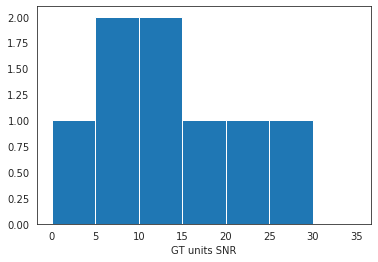

In [4]:
fig, ax = plt.subplots()
ax.hist(snr['snr'].values, bins=np.arange(0, 40, 5))
ax.set_xlabel('GT units SNR')

## Run all sorters

In [5]:
sorter_list = ['herdingspikes', 'ironclust', 'kilosort2',  'kilosort',
                'spykingcircus', 'tridesclous']

In [ ]:
study = GroundTruthStudy(study_folder)

study.run_sorters(sorter_list, mode='keep', verbose=False)

WARNING! The recording contains group. In order to spike sort by 'group' use grouping_property='group' as argument.
# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 20000
# Localization On
# Number of recorded channels: 252
# Analysing frames: 6000000; Seconds: 300.0
# Frames before spike in cutout: 4
# Frames after spike in cutout: 20
# tcuts: 32 48
# tInc: 100000
# Analysing frames from -32 to 100048  (0.0%)
# Analysing frames from 99968 to 200048  (1.7%)
# Analysing frames from 199968 to 300048  (3.3%)
# Analysing frames from 299968 to 400048  (5.0%)
# Analysing frames from 399968 to 500048  (6.7%)
# Analysing frames from 499968 to 600048  (8.3%)
# Analysing frames from 599968 to 700048  (10.0%)
# Analysing frames from 699968 to 800048  (11.7%)
# Analysing frames from 799968 to 900048  (13.3%)
# Analysing frames from 899968 to 1000048  (15.0%)
# Analysing frames from 999968 to 1100048  (16.7%)
# Analysing frames from 1099968 to 

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   30.8s remaining:  1.5min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   33.3s remaining:    6.7s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   33.6s finished


Number of estimated units: 1684
Saving to /media/samuel/dataspikesorting/DataSpikeSortingHD2/Pierre/zenodo/study_gt252/sorter_folders/20160415_patch2/herdingspikes/HS2_sorted.hdf5
WARNING! The recording contains group. In order to spike sort by 'group' use grouping_property='group' as argument.
RUNNING SHELL SCRIPT: /tmp/tmp_shellscript09fbnvnt/script.sh


/usr/lib/python3.6/subprocess.py:786: ResourceWarning: subprocess 27949 is still running
  ResourceWarning, source=self)


WARNING! The recording contains group. In order to spike sort by 'group' use grouping_property='group' as argument.
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptcdk1ufup/script.sh
WARNING! The recording contains group. In order to spike sort by 'group' use grouping_property='group' as argument.


## Run comparison with ground truth and retreive result tables

In [ ]:
# this copy sorting is necessary to copy results from sorter
# into a centralize folder with all results
study.copy_sortings()

# this run all comparison sto GT
study.run_comparisons(exhaustive_gt=False, match_score=0.1, overmerged_score=0.2)

In [ ]:
# this retrieve results
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

In [ ]:
## Run times

In [ ]:
dataframes['run_times']

In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=dataframes['run_times'], x='sorter_name', y='run_time', ax=ax, order=sorter_list)

sns.set_palette(sns.color_palette("Set1"))
ax.set_yscale('log')
ax.set_ylabel('Run time (s)');
ax.set_xlabel(None);
ax.set_xticklabels(sorter_list, rotation=40, ha='right');

## accuracy/precision/recall scores per sorters

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
fig.tight_layout()

sns.set_palette(sns.color_palette("Set1"))

df = pd.melt(dataframes['perf_by_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('accuracy','precision', 'recall'))
# df.assign(Generation=df.metric.map({'metric':'Metric','accuracy': 'Accuracy', 'precision': 'Precision', 'recall': 'Recall'}))
p = sns.catplot(data=df, x='sorter_name', y='score', hue='metric', kind='swarm', dodge=True, ax=ax, 
                order=sorter_list, legend_out=True, s=4)
plt.close(p.fig)
ax.legend(['Accuracy', 'Precision', 'Recall'], labelspacing=0.2,
          bbox_to_anchor=(1, 0.5), loc=2, borderaxespad=0., frameon=False)
ax.set_xticklabels(sorter_list, rotation=30, ha='center')
ax.set_xlabel(None);
ax.set_ylabel('Score');
clear_axes(ax)

In [ ]:
sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], x='precision', y='recall', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)

In [ ]:
## Accuracy vns SNR

In [ ]:
df = dataframes['perf_by_units']


# add snr to the by-unit table
df['snr'] = None
for gt_id in snr.index:
    df['snr'].loc[df['gt_unit_id']==gt_id] = snr.at[gt_id, 'snr']
df



sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], x='snr', y='accuracy', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)
for i,ax in enumerate(g.axes):
    ax.set_title(sorter_list[i])
    ax.set_xlabel('')

    g.axes[0].set_xlabel('SNR');

g.axes[0].set_ylabel('Accuracy');